# import des données

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id="72eb7803-e874-44cb-b6d9-33f2fa3eb88c",
    resource_group_name="vpoutotrg",
    workspace_name="mlstudio-groupe4"
)

data_asset = ml_client.data.get("allo_cine", version="2.2.1")

df = pd.read_parquet(data_asset.path)
df = df[df['french_first_week_boxoffice'].notna()]
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d', errors='coerce')
df = df[df['date'].notna()]
df['us_first_week_boxoffice'] = df['us_first_week_boxoffice'].fillna(0)
df.head()

Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


,actors,critics_score,date,directors,editor,genre,langage,length,nationality,viewers_score,us_first_week_boxoffice,french_first_week_boxoffice,french_visa,title,vo_title,url
0,"[Arieh Worthalter, Arthur Harari, Stéphan Guér...",4.4,2023-09-27,[Cédric Kahn],Ad Vitam,"[Policier, Drame, Historique, Judiciaire]",[Français],116.0,[France],3.9,0.0,110011.0,157303,Le Procès Goldman,None,/article/fichearticle_gen_carticle=1000093547....
1,"[Monica Bellucci, Vincent Cassel, Albert Dupon...",3.5,2020-08-26,[Gaspar Noé],Carlotta Films,"[Drame, Thriller]","[Anglais, Français, Italien, Espagnol]",90.0,[France],NaN,0.0,2905.0,153336,Irréversible - Inversion Intégrale,None,/article/fichearticle_gen_carticle=18692477.html
2,[Thom Hoffman],2.8,2024-08-07,"[Richard Claus, Karsten Kiilerich]",Le Pacte,"[Aventure, Animation, Comédie, Famille]",[Néerlandais],84.0,"[Danemark, France, Allemagne, Pays-Bas]",3.0,0.0,39119.0,160622,Petit Panda en Afrique,Panda Bear in Africa,/article/fichearticle_gen_carticle=1000096064....
3,"[Lou de Laâge, Raphaël Personnaz, Isabelle Car...",3.3,2022-12-21,[Olivier Treiner],SND,[Drame],[Français],120.0,[France],3.8,0.0,64039.0,152607,Le Tourbillon de la vie,None,/article/fichearticle_gen_carticle=1000006465....
4,"[Michael B. Jordan, Jamie Foxx, Brie Larson, R...",3.0,2020-01-29,[Destin Daniel Cretton],Warner Bros. France,"[Biopic, Drame]",[Anglais],137.0,[U.S.A.],4.1,9713228.0,113153.0,152118,La Voie de la justice,Just Mercy,/video/player_gen_cmedia=19586793&cfilm=239735...


In [2]:
df.dtypes

actors                                 object
critics_score                         float64
date                           datetime64[ns]
directors                              object
editor                                 object
genre                                  object
langage                                object
length                                float64
nationality                            object
viewers_score                         float64
us_first_week_boxoffice               float64
french_first_week_boxoffice           float64
french_visa                            object
title                                  object
vo_title                               object
url                                    object
dtype: object

In [3]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

file_name = "cncAffluence"
version="2.0.0"

ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id="72eb7803-e874-44cb-b6d9-33f2fa3eb88c",
    resource_group_name="vpoutotrg",
    workspace_name="mlstudio-groupe4"
)

data_asset = ml_client.data.get(file_name, version=version)

df_afluence = pd.read_parquet(data_asset.path)
df_afluence.head()

Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


,box_office,is_prediction
month,,
2009-01-01,15.148333,0
2009-02-01,19.348000,0
2009-03-01,20.087500,0
2009-04-01,16.975000,0
2009-05-01,14.528333,0


# Préparation du jeux d'entrainement et de test

In [4]:
def remove_target_outliers(df, target_column, factor=1.5):
    """
    Supprime les outliers de la variable cible.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Le dataframe à nettoyer
    target_column : str
        Nom de la colonne cible
    factor : float, default=1.5
        Facteur multiplicatif de l'IQR pour définir le seuil des outliers
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe sans outliers sur la cible
    """
    # Calcul des statistiques
    Q1 = df[target_column].quantile(0.25)
    Q3 = df[target_column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Définition des bornes
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # Filtrage
    df_clean = df[(df[target_column] >= lower_bound) & (df[target_column] <= upper_bound)]
    
    # Statistiques sur les outliers supprimés
    n_removed = len(df) - len(df_clean)
    print(f"Nombre d'outliers supprimés : {n_removed} ({n_removed/len(df)*100:.2f}%)")
    print(f"Valeur minimale conservée : {df_clean[target_column].min()}")
    print(f"Valeur maximale conservée : {df_clean[target_column].max()}")
    
    return df_clean

def remove_outliers_zscore(df, columns, threshold=3.0):
    """
    Supprime les outliers basés sur le z-score (nombre d'écarts-types par rapport à la moyenne).
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Le dataframe à nettoyer
    columns : list
        Liste des colonnes à traiter
    threshold : float, default=3.0
        Seuil de z-score au-delà duquel une valeur est considérée comme outlier
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe sans outliers
    """
    df_clean = df.copy()
    
    for col in columns:
        # Calcul des z-scores
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        z_scores = abs((df_clean[col] - mean) / std)
        
        # Suppression des outliers
        df_clean = df_clean[z_scores < threshold]
    
    # Affichage du nombre de lignes supprimées
    n_removed = len(df) - len(df_clean)
    print(f"Nombre de lignes supprimées : {n_removed} ({n_removed/len(df)*100:.2f}%)")
    
    return df_clean

def put_national_affluence(x):
    date = pd.to_datetime(f"{x.year}-{x.month:02d}-01")
    return df_afluence.loc[date, 'box_office'] if date in df_afluence.index else None

features_of_interest = [
    'french_prod',
    'date',
    'directors',
    'editor',
    'genre',
    'length',
    'number_actors',
    'usa_prod',
    'national_affluence',
    'french_langage', 
    'english_langage'
]

info_film = ['french_visa', 'title', 'vo_title', 'url']
numerical_features = ['length', 'national_affluence', 'french_langage', 'english_langage', 'french_prod', 'usa_prod', 'number_actors']
date_feature = ['date']
categorical_features = ['editor']
list_categorical_features = ['genre', 'directors']
target = 'french_first_week_boxoffice'

def pre_transform_df(df, **kwargs):
    # Paramètres avec valeurs par défaut
    national_affluence = kwargs.get("national_affluence", True)
    remove_outliers = kwargs.get("remove_outliers", True)
    method_outliers = kwargs.get("method_outliers", "IQR")
    factor_outliers = kwargs.get("factor_outliers", 1.5)

    # Paramètres obligatoires attendus dans kwargs
    features_of_interest = kwargs.get("features_of_interest")
    numerical_features = kwargs.get("numerical_features")
    date_feature = kwargs.get("date_feature")
    categorical_features = kwargs.get("categorical_features")
    list_categorical_features = kwargs.get("list_categorical_features")
    target = kwargs.get("target", "french_first_week_boxoffice")

    # Validation des features
    try:
        all_expected = numerical_features + date_feature + categorical_features + list_categorical_features
        missing_features = [f for f in all_expected if f not in features_of_interest]
        if missing_features:
            raise ValueError(f"Les features suivantes sont manquantes dans features_of_interest : {missing_features}")
    except Exception as e:
        print(f"[Erreur de validation des features] {e}")

    # Remplissage des NaN dans certaines colonnes
    for col in ['genre', 'langage', 'nationality', 'actors']:
        df[col] = df[col].mask(df[col].isna(), ['no value'])

    # Ajout de la colonne national_affluence
    if national_affluence:
        df['national_affluence'] = df['date'].apply(put_national_affluence)

    # Création des variables dérivées
    if 'french_prod' in features_of_interest:
        df['french_prod'] = df['nationality'].apply(lambda x: 1 if "France" in x else 0)
    if 'usa_prod' in features_of_interest:
        df['usa_prod'] = df['nationality'].apply(lambda x: 1 if "U.S.A." in x else 0)
    if 'french_langage' in features_of_interest:
        df['french_langage'] = df['langage'].apply(lambda x: 1 if "Français" in x else 0)
    if 'english_langage' in features_of_interest:
        df['english_langage'] = df['langage'].apply(lambda x: 1 if "Anglais" in x else 0)
    if 'number_actors' in features_of_interest:
        df['number_actors'] = df['actors'].apply(lambda x: len(x))

    # Traitement des outliers
    if remove_outliers:
        if method_outliers == "IQR":
            df = remove_target_outliers(df, target, factor=factor_outliers)
        elif method_outliers == "z-scores":
            df = remove_outliers_zscore(df, [target], threshold=factor_outliers)
        else:
            print(f"{method_outliers} is not a valid method for outliers")

    return df, df[features_of_interest], df[target]


giga_big_param = {
    "national_affluence" : True,
    "remove_outliers" : True,
    "method_outliers" : "z-scores", # "IQR" ou "z-scores"
    "features_of_interest" : features_of_interest,
    "numerical_features" : numerical_features,
    "date_feature" : date_feature,
    "categorical_features" : categorical_features,
    "list_categorical_features" : list_categorical_features,
    "target" : target
}


df, X, y = pre_transform_df(df, **giga_big_param)

Nombre de lignes supprimées : 144 (1.57%)


In [5]:
def time_based_split(df, test_years=3, test_ratio=0.5):
    """
    Crée un découpage train/test basé sur le temps.
    
    Args:
        df: DataFrame avec les données
        test_years: Nombre d'années récentes à considérer pour le découpage
        test_ratio: Proportion des films des années récentes à mettre dans le test set
    
    Returns:
        indices_train, indices_test
    """
    # Convertir en datetime si ce n'est pas déjà fait
    df["date"] = pd.to_datetime(df["date"])
    
    # Déterminer la date limite pour les dernières années
    max_date = df["date"].max()
    cutoff_date = pd.Timestamp(year=max_date.year - test_years, month=1, day=1)
    
    # Créer un masque pour les films récents
    recent_mask = df["date"] >= cutoff_date
    
    # Séparer les indices en entrainement et test
    old_indices = df[~recent_mask].index.tolist()
    recent_indices = df[recent_mask].index.tolist()
    
    # Trier les indices récents par date pour pouvoir prendre un film sur deux
    recent_sorted = sorted([(idx, df.loc[idx, "date"]) for idx in recent_indices], 
                           key=lambda x: x[1])
    recent_indices_sorted = [item[0] for item in recent_sorted]
    
    # Prendre un film sur deux dans les données récentes pour le test
    test_size = int(len(recent_indices_sorted) * test_ratio)
    
    # Option 1: Prendre aléatoirement test_ratio des films récents
    np.random.seed(42)
    test_indices = np.random.choice(recent_indices_sorted, size=test_size, replace=False)
    
    # Option 2: Prendre un film sur deux chronologiquement
    # test_indices = recent_indices_sorted[::int(1/test_ratio)] if test_ratio <= 0.5 else recent_indices_sorted

    train_indices = [idx for idx in df.index if idx not in test_indices]
    
    print(f"Découpage temporel: {len(train_indices)} films pour l'entrainement, {len(test_indices)} films pour le test")
    print(f"Plage de dates d'entrainement: {df.loc[train_indices, "date"].min()} à {df.loc[train_indices, "date"].max()}")
    print(f"Plage de dates de test: {df.loc[test_indices, "date"].min()} à {df.loc[test_indices, "date"].max()}")
    
    return train_indices, test_indices

In [6]:
train_indices, test_indices = time_based_split(df, test_years=3, test_ratio=0.5)
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

Découpage temporel: 8247 films pour l'entrainement, 760 films pour le test
Plage de dates d'entrainement: 1994-11-23 00:00:00 à 2025-05-28 00:00:00
Plage de dates de test: 2022-01-05 00:00:00 à 2025-03-05 00:00:00


# preprocessor, modèle et Optuna

In [8]:
from sklearn.model_selection import TimeSeriesSplit

def time_series_cv_split(X_train, y_train, n_splits=5):
    """
    Crée plusieurs découpages temporels pour la validation croisée.
    
    Args:
        X_train: Features d'entrainement
        y_train: Target d'entrainement
        n_splits: Nombre de découpages
    
    Returns:
        Une liste de tuples (train_idx, val_idx)
    """
    # Assurons-nous que X_train contient la colonne date
    if  "date" not in X_train.columns:
        raise ValueError(f"La colonne 'date' n'est pas dans X_train")
    
    # Trier les indices par date
    sorted_indices = X_train.sort_values(by= "date").index
    
    # Utiliser TimeSeriesSplit pour créer des découpages temporels
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Convertir les découpages en indices réels
    cv_indices = []
    for train_idx, val_idx in tscv.split(sorted_indices):
        real_train_idx = sorted_indices[train_idx]
        real_val_idx = sorted_indices[val_idx]
        cv_indices.append((real_train_idx, real_val_idx))
    
    return cv_indices

In [9]:
print(type(df['genre'].iloc[0])) 

<class 'numpy.ndarray'>


In [10]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlbs = {}  # Stocke un MultiLabelBinarizer pour chaque colonne
    
    def fit(self, X, y=None):
        for col in X.columns:
            self.mlbs[col] = MultiLabelBinarizer()
            self.mlbs[col].fit(X[col])
        return self
    
    def transform(self, X):
        transformed_list = []
        for col in X.columns:
            transformed = self.mlbs[col].transform(X[col])
            new_columns = [f"{col}_{label}" for label in self.mlbs[col].classes_]
            transformed_list.append(pd.DataFrame(transformed, columns=new_columns, index=X.index))
        return pd.concat(transformed_list, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        # Collecter tous les noms de colonnes de sortie
        feature_names = []
        for col in self.mlbs.keys():
            feature_names.extend([f"{col}_{label}" for label in self.mlbs[col].classes_])
        return np.array(feature_names)

class CustomDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_out = ['year', 'month', 'day', 'dayofweek']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        result = pd.DataFrame({
            'year': X['date'].dt.year,
            'month': X['date'].dt.month,
            'day': X['date'].dt.day,
            'dayofweek': X['date'].dt.dayofweek
        })
        return result
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Fonction pour créer le pipeline avec des hyperparamètres spécifiques
def create_model(params, numerical_features, date_feature, categorical_features, list_categorical_features):
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    date_transformer = Pipeline(steps=[
        ('date_features', CustomDateTransformer())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    list_categorical_transformer = Pipeline(steps=[
        ('multi_label', MultiLabelBinarizerTransformer())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('date', date_transformer, date_feature),
            ('cat', categorical_transformer, categorical_features),
            ('list', list_categorical_transformer, list_categorical_features)
        ],
        remainder='passthrough'
    )
    
    xgboost_reg = xgb.XGBRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        gamma=params['gamma'],
        scale_pos_weight=params['scale_pos_weight'],
        random_state=42
    )
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('xgboost', xgboost_reg)
    ])
    
    return model


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:

# Fonction objective pour Optuna
def objective(trial, X_train, y_train, X_val, y_val, numerical_features, date_feature, categorical_features, list_categorical_features):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 2.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 2.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 1.2)
    }
    
    model = create_model(params, numerical_features, date_feature, categorical_features, list_categorical_features)
    model.fit(X_train, y_train)
    
    y_pred_val = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred_val)
    
    return rmse

# Fonction principale d'optimisation
def optimize_xgboost(X_train, y_train, numerical_features, date_feature, categorical_features, list_categorical_features, n_trials=100):
    # Création d'un ensemble de validation
    from sklearn.model_selection import train_test_split
    X_train_opt, X_val, y_train_opt, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Création de l'étude Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(
        lambda trial: objective(
            trial, X_train_opt, y_train_opt, X_val, y_val,
            numerical_features, date_feature, categorical_features, list_categorical_features
        ),
        n_trials=n_trials
    )
    
    print("Meilleurs paramètres trouvés :")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")
    
    # Entraînement du modèle final avec les meilleurs paramètres
    best_params = study.best_params
    best_model = create_model(best_params, numerical_features, date_feature, categorical_features, list_categorical_features)
    best_model.fit(X_train, y_train)
    
    return best_model, study

# Fonction pour évaluer le modèle
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")
    
    return mae, rmse, r2

# Visualisation des résultats d'optimisation
def plot_optimization_history(study):
    import matplotlib.pyplot as plt
    
    # Graphique des valeurs objectives au fil des essais
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(study.trials)), [t.value for t in study.trials], marker='o', linestyle='-')
    plt.xlabel('Numéro d\'essai')
    plt.ylabel('RMSE')
    plt.title('Évolution du RMSE pendant l\'optimisation')
    plt.grid(True)
    plt.show()
    
    # Graphiques d'importance des paramètres
    try:
        importances = optuna.importance.get_param_importances(study)
        plt.figure(figsize=(10, 6))
        plt.bar(importances.keys(), importances.values())
        plt.xlabel('Hyperparamètre')
        plt.ylabel('Importance')
        plt.title('Importance des hyperparamètres')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except:
        print("Impossible de calculer l'importance des paramètres.")

In [12]:
# # Nombre d'essais à réaliser (ajustez selon vos ressources de calcul)
# n_trials = 5
# import warnings
# warnings.filterwarnings('ignore')

# # Optimisation
# best_model, study = optimize_xgboost(
#     X_train, y_train,
#     numerical_features, date_feature, categorical_features, list_categorical_features,
#     n_trials=n_trials
# )


In [13]:
# mae, rmse, r2 = evaluate_model(best_model, X_test, y_test)

In [14]:
# plot_optimization_history(study)

In [15]:
import matplotlib.pyplot as plt

def objective_time_based(trial, X, y, cv_splits, numerical_features, 
                         date_feature, categorical_features, list_categorical_features):
    # Définir les hyperparamètres
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 0.5, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 1.2)
    }
    
    # Mesurer la performance sur chaque découpage
    rmse_scores = []
    for train_idx, val_idx in cv_splits:
        # Extraire les données pour ce découpage
        X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
        y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]
        
        # Créer et entrainer le modèle
        model = create_model(params, numerical_features, date_feature, categorical_features, list_categorical_features)
        model.fit(X_train_fold, y_train_fold)
        
        # Évaluer le modèle
        y_pred_val = model.predict(X_val_fold)
        rmse = root_mean_squared_error(y_val_fold, y_pred_val)
        rmse_scores.append(rmse)
    
    # Retourner la moyenne des RMSE
    return np.mean(rmse_scores)


def optimize_xgboost_time_based(df, X, y, target_column,
                               numerical_features, date_feature, categorical_features, list_categorical_features,
                               test_years=3, test_ratio=0.5, n_cv_splits=3, n_trials=100):
    """
    Optimise un modèle XGBoost avec validation temporelle.
    
    Args:
        df: DataFrame complet (pour le découpage temporel)
        X: Features
        y: Target
        target_column: Nom de la colonne cible
        numerical_features, date_feature, categorical_features, list_categorical_features: Listes de colonnes
        test_years: Nombre d'années récentes à considérer pour le test
        test_ratio: Proportion des films récents à utiliser pour le test
        n_cv_splits: Nombre de découpages pour la validation croisée
        n_trials: Nombre d'essais pour Optuna
    
    Returns:
        best_model, default_model, study, train_indices, test_indices
    """
    # Créer le découpage train/test basé sur le temps
    train_indices, test_indices = time_based_split(df, test_years, test_ratio)
    
    # Extraire les données d'entrainement et de test
    X_train, X_test = X.loc[train_indices], X.loc[test_indices]
    y_train, y_test = y.loc[train_indices], y.loc[test_indices]
    
    # Visualiser la distribution temporelle des données
    plt.figure(figsize=(12, 6))
    plt.scatter(X_train["date"], y_train, alpha=0.5, label='Entrainement')
    plt.scatter(X_test["date"], y_test, alpha=0.5, label='Test')
    plt.title('Distribution temporelle des données d\'entrainement et de test')
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Créer les découpages pour la validation croisée temporelle
    cv_splits = time_series_cv_split(X_train, y_train, n_splits=n_cv_splits)
    
    # Visualiser les découpages CV
    plt.figure(figsize=(12, 6))
    for i, (train_idx, val_idx) in enumerate(cv_splits):
        # Extraire les dates min et max pour chaque découpage
        train_dates = X_train.loc[train_idx, "date"]
        val_dates = X_train.loc[val_idx, "date"]
        
        plt.plot([train_dates.min(), train_dates.max()], [i, i], 'b-', linewidth=2)
        plt.plot([val_dates.min(), val_dates.max()], [i, i], 'r-', linewidth=2)
    
    plt.title('Découpages de validation croisée temporelle')
    plt.xlabel('Date')
    plt.ylabel('Numéro du découpage')
    plt.legend(['Entrainement', 'Validation'])
    plt.grid(True)
    plt.show()
    
    # Entrainer un modèle par défaut comme référence
    default_model = Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numerical_features),
                ('date', Pipeline(steps=[('date_features', CustomDateTransformer())]), date_feature),
                ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features),
                ('list', Pipeline(steps=[('multi_label', MultiLabelBinarizerTransformer())]), list_categorical_features)
            ],
            remainder='passthrough'
        )),
        ('xgboost', xgb.XGBRegressor(random_state=42))
    ])
    
    default_model.fit(X_train, y_train)
    default_test_pred = default_model.predict(X_test)
    default_rmse_test = root_mean_squared_error(y_test, default_test_pred)
    default_mae_test = mean_absolute_error(y_test, default_test_pred)
    default_r2_test = r2_score(y_test, default_test_pred)
    
    print("\nPerformances du modèle par défaut sur le jeu de test:")
    print(f"MAE: {default_mae_test}")
    print(f"RMSE: {default_rmse_test}")
    print(f"R²: {default_r2_test}")
    
    # Optimisation avec Optuna
    study = optuna.create_study(direction='minimize')
    
    # Inclure le modèle par défaut comme premier essai
    default_params = {
        'n_estimators': 100,  # valeur par défaut
        'max_depth': 6,       # valeur par défaut
        'learning_rate': 0.3, # valeur par défaut
        'subsample': 1.0,     # valeur par défaut
        'colsample_bytree': 1.0, # valeur par défaut
        'min_child_weight': 1,   # valeur par défaut
        'reg_alpha': 1e-8,       # bug avec 0
        'reg_lambda': 1,      # valeur par défaut
        'gamma': 0,           # valeur par défaut
        'scale_pos_weight': 1.0  # valeur par défaut
    }
    
    # Ajouter manuellement l'essai par défaut
    study.enqueue_trial(default_params)
    
    # Optimisation avec validation temporelle
    study.optimize(
        lambda trial: objective_time_based(
            trial, X_train, y_train, cv_splits,
            numerical_features, date_feature, categorical_features, list_categorical_features
        ),
        n_trials=n_trials
    )
    
    print("Meilleurs paramètres trouvés :")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")
    
    # Entraînement du modèle final avec les meilleurs paramètres
    best_params = study.best_params
    best_model = create_model(best_params, numerical_features, date_feature, categorical_features, list_categorical_features)
    best_model.fit(X_train, y_train)
    
    # Évaluation du modèle optimisé
    best_test_pred = best_model.predict(X_test)
    best_rmse_test = root_mean_squared_error(y_test, best_test_pred)
    best_mae_test = mean_absolute_error(y_test, best_test_pred)
    best_r2_test = r2_score(y_test, best_test_pred)
    
    print("\nPerformances du modèle optimisé sur le jeu de test:")
    print(f"MAE: {best_mae_test}")
    print(f"RMSE: {best_rmse_test}")
    print(f"R²: {best_r2_test}")
    
    # Visualiser les prédictions vs réalité
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, default_test_pred, alpha=0.5, label='Modèle par défaut')
    plt.scatter(y_test, best_test_pred, alpha=0.5, label='Modèle optimisé')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.title('Prédictions vs Réalité')
    plt.xlabel('Box-office réel')
    plt.ylabel('Box-office prédit')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Visualiser l'erreur en fonction du temps
    plt.figure(figsize=(12, 6))
    default_errors = np.abs(y_test - default_test_pred)
    best_errors = np.abs(y_test - best_test_pred)
    plt.scatter(X_test["date"], default_errors, alpha=0.5, label='Erreur modèle par défaut')
    plt.scatter(X_test["date"], best_errors, alpha=0.5, label='Erreur modèle optimisé')
    plt.title('Erreur absolue en fonction du temps')
    plt.xlabel('Date')
    plt.ylabel('Erreur absolue')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_model, default_model, study, train_indices, test_indices


In [16]:
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

date_transformer = Pipeline(steps=[
    ('date_features', CustomDateTransformer())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

list_categorical_transformer = Pipeline(steps=[
    ('multi_label', MultiLabelBinarizerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('date', date_transformer, date_feature),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_categorical_transformer, list_categorical_features)
    ],
    remainder='passthrough'
)

xgboost_model = Pipeline([
    ('preprocessor', preprocessor),  
    ('xgboost', xgb.XGBRegressor())
])

xgboost_model.fit(X_train,y_train)
y_pred = xgboost_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 78563.60134568466
RMSE: 187016.5343443415
R²: 0.48184771355503064


# Recherche et meilleurs modèle

Découpage temporel: 8247 films pour l'entrainement, 760 films pour le test
Plage de dates d'entrainement: 1994-11-23 00:00:00 à 2025-05-28 00:00:00
Plage de dates de test: 2022-01-05 00:00:00 à 2025-03-05 00:00:00


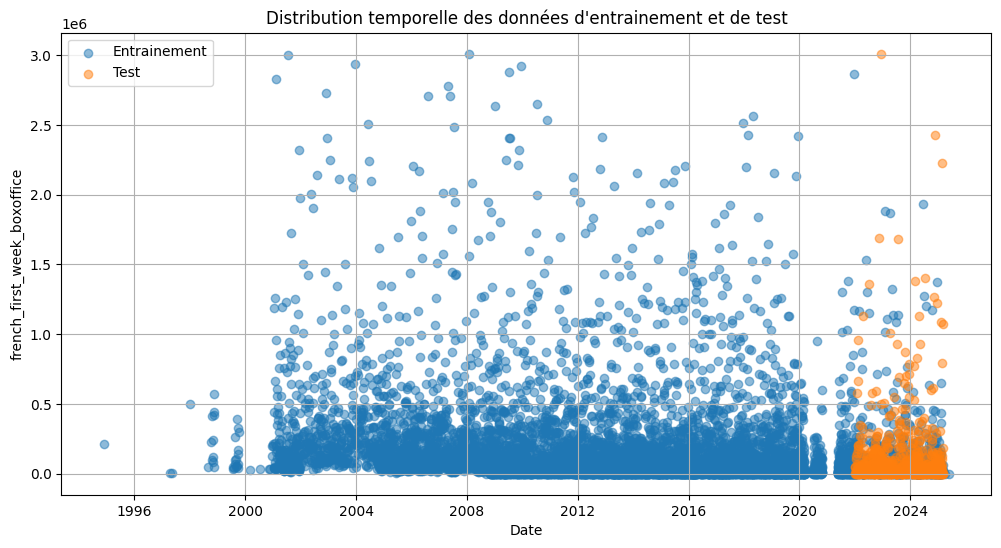

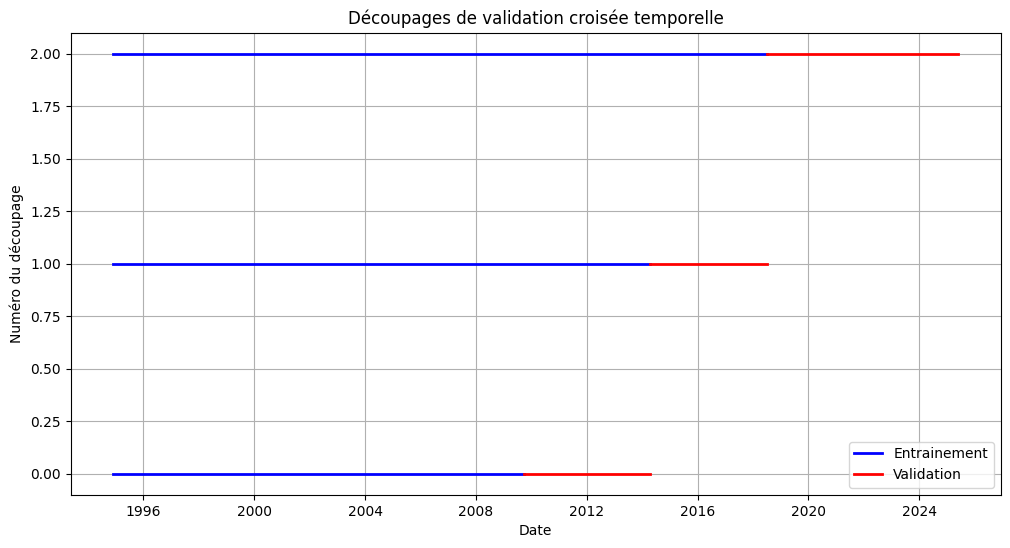

[I 2025-04-11 14:57:57,562] A new study created in memory with name: no-name-b17c64e6-13cd-4ccb-945e-5e91e5027915



Performances du modèle par défaut sur le jeu de test:
MAE: 78563.60134568466
RMSE: 187016.5343443415
R²: 0.48184771355503064


[I 2025-04-11 14:58:02,276] Trial 0 finished with value: 206246.22145182686 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'reg_alpha': 1e-08, 'reg_lambda': 1.0, 'gamma': 0.0, 'scale_pos_weight': 1.0}. Best is trial 0 with value: 206246.22145182686.
[I 2025-04-11 14:58:08,290] Trial 1 finished with value: 201529.67029607308 and parameters: {'n_estimators': 170, 'max_depth': 5, 'learning_rate': 0.07758248909743787, 'subsample': 0.7587553255660868, 'colsample_bytree': 0.8465133408339983, 'min_child_weight': 2, 'reg_alpha': 0.017765268031277974, 'reg_lambda': 3.9958173833669066e-07, 'gamma': 0.20340624158196619, 'scale_pos_weight': 1.0959930193339273}. Best is trial 1 with value: 201529.67029607308.
[I 2025-04-11 14:58:18,707] Trial 2 finished with value: 199624.87711070423 and parameters: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.07089036322435005, 'subsample': 0.7227908581317076

Meilleurs paramètres trouvés :
    n_estimators: 260
    max_depth: 10
    learning_rate: 0.0333693511716267
    subsample: 0.7741537702880745
    colsample_bytree: 0.7675676487966403
    min_child_weight: 1
    reg_alpha: 5.396187528737314e-06
    reg_lambda: 8.518979178040304e-05
    gamma: 0.38046570690251297
    scale_pos_weight: 0.8006865510828747

Performances du modèle optimisé sur le jeu de test:
MAE: 71670.9376018725
RMSE: 172676.31704715706
R²: 0.5582638275046672


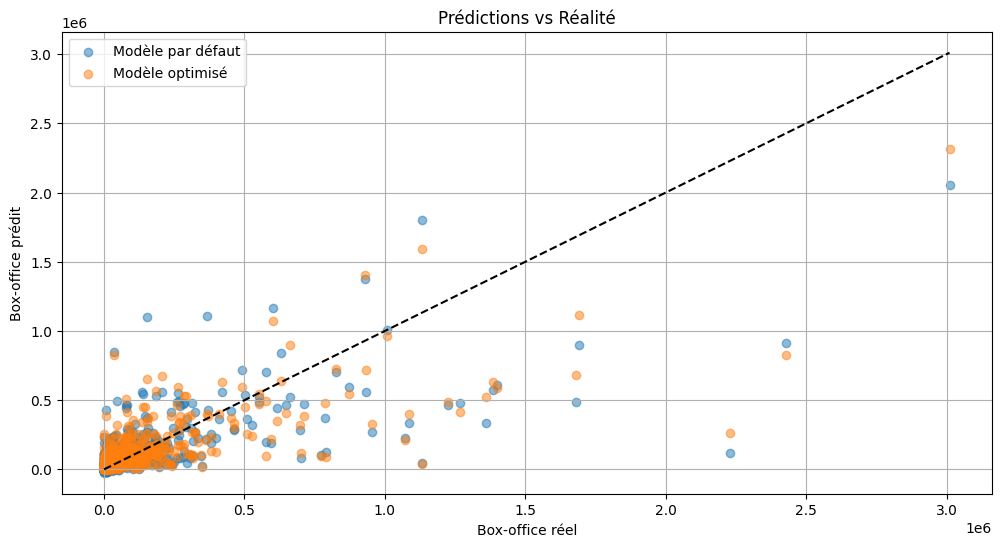

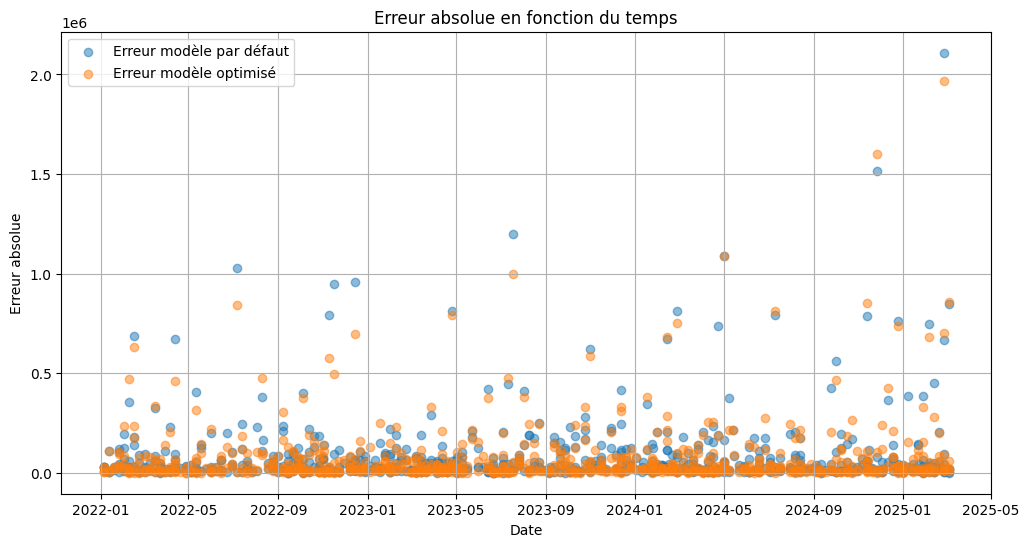

In [ ]:
import warnings
warnings.filterwarnings('ignore')

best_model, default_model, study, train_indices, test_indices = optimize_xgboost_time_based(
    df=df, 
    X=X, y=y,
    target_column='french_first_week_boxoffice',
    numerical_features=numerical_features,
    date_feature=date_feature,
    categorical_features=categorical_features,
    list_categorical_features=list_categorical_features,
    test_years=3,    
    test_ratio=0.5,     
    n_cv_splits=3,     
    n_trials=200         
)

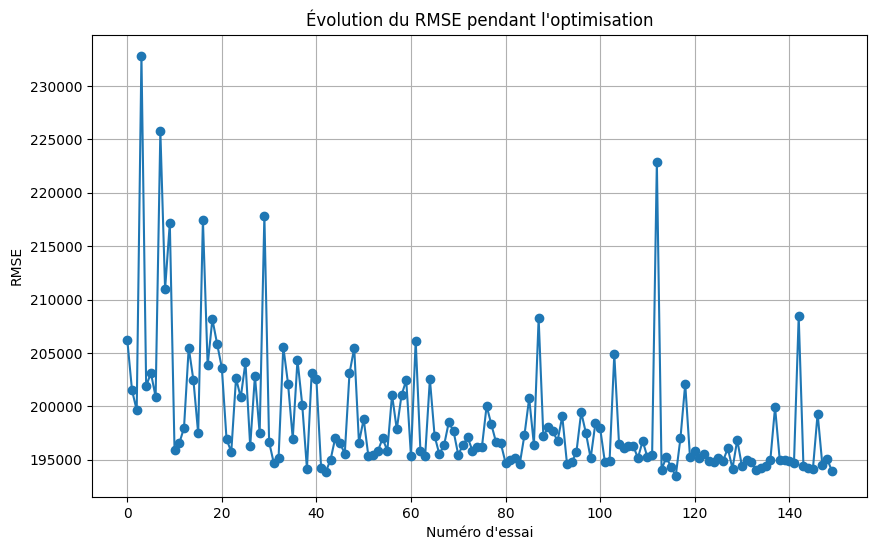

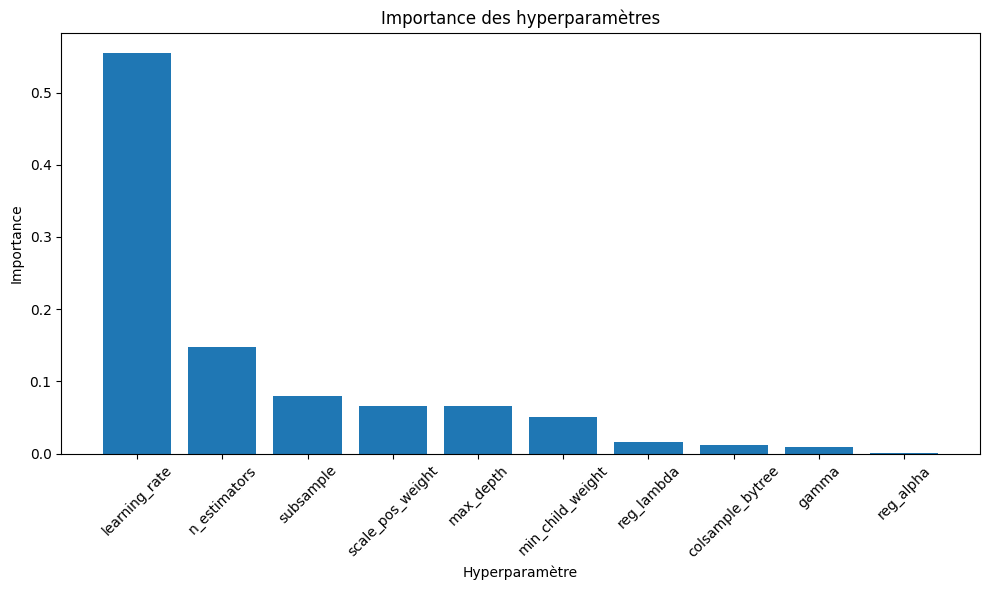

In [18]:
plot_optimization_history(study)

In [19]:
# if hasattr(best_model[-1], 'feature_importances_'):
#     # Obtenir les noms des features après prétraitement
#     preprocessor = best_model.named_steps['preprocessor']
#     feature_names = preprocessor.get_feature_names_out()
    
#     # Obtenir les importances
#     importances = best_model.named_steps['xgboost'].feature_importances_
    
#     # Trier par importance décroissante
#     indices = np.argsort(importances)[::-1]
#     print(len(indices))
#     # Afficher les importances
#     plt.figure(figsize=(12, 8))
#     plt.title('Importance des features')
#     plt.bar(range(len(indices)), importances[indices], align='center')
#     plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
#     plt.tight_layout()
#     plt.show()

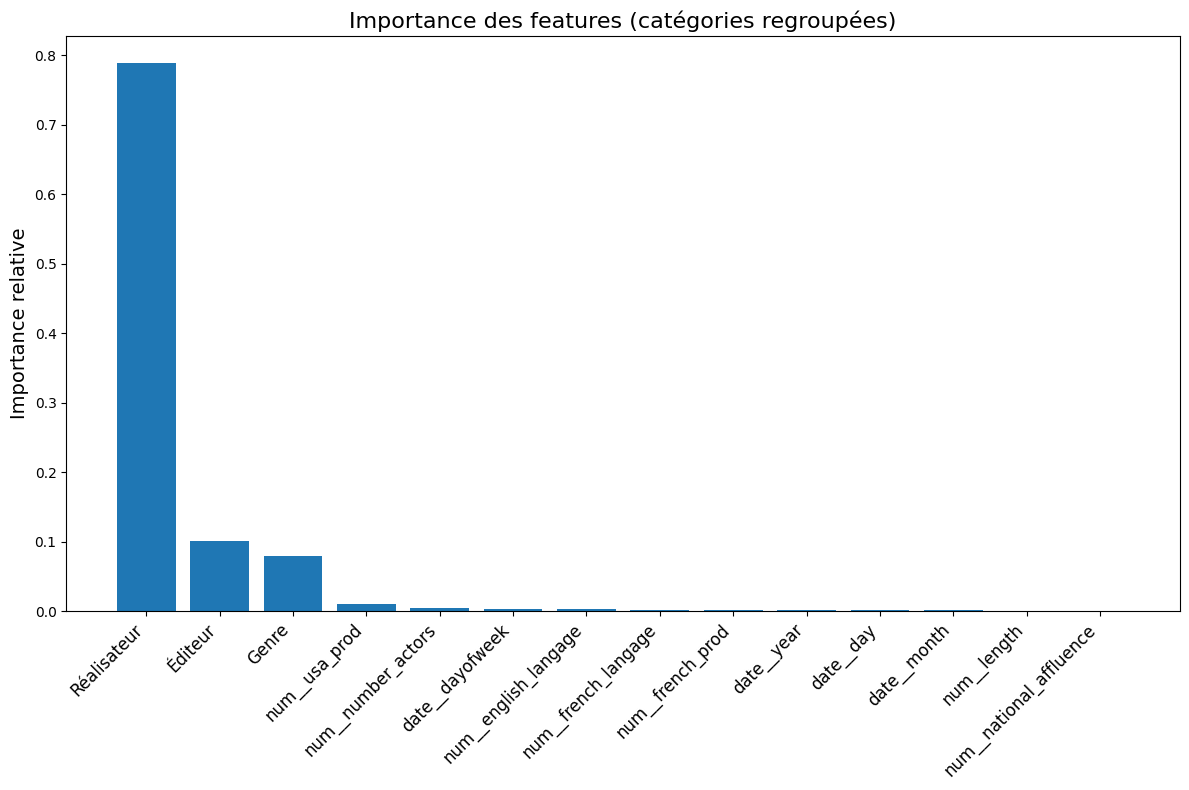

Importance des features regroupées:
Réalisateur: 0.7885
Éditeur: 0.1016
Genre: 0.0798
num__usa_prod: 0.0100
num__number_actors: 0.0052
date__dayofweek: 0.0034
num__english_langage: 0.0029
num__french_langage: 0.0017
num__french_prod: 0.0014
date__year: 0.0013
date__day: 0.0012
date__month: 0.0012
num__length: 0.0009
num__national_affluence: 0.0007


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

if hasattr(best_model[-1], 'feature_importances_'):
    # Obtenir les noms des features après prétraitement
    preprocessor = best_model.named_steps['preprocessor']
    feature_names = preprocessor.get_feature_names_out()
    
    # Obtenir les importances
    importances = best_model.named_steps['xgboost'].feature_importances_
    
    # Créer un DataFrame pour faciliter le regroupement
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Initialiser un dictionnaire pour stocker les importances regroupées
    grouped_importances = {}
    
    # Regrouper les features par préfixe
    for feature, importance in zip(feature_names, importances):
        if feature.startswith('cat__editor_'):
            key = 'Éditeur'
            if key not in grouped_importances:
                grouped_importances[key] = 0
            grouped_importances[key] += importance
        elif feature.startswith('list__genre_'):
            key = 'Genre'
            if key not in grouped_importances:
                grouped_importances[key] = 0
            grouped_importances[key] += importance
        elif feature.startswith('list__directors_'):
            key = 'Réalisateur'
            if key not in grouped_importances:
                grouped_importances[key] = 0
            grouped_importances[key] += importance
        else:
            # Garder les autres features telles quelles
            grouped_importances[feature] = importance
    
    # Convertir en DataFrame pour le tri et l'affichage
    grouped_df = pd.DataFrame({
        'feature': list(grouped_importances.keys()),
        'importance': list(grouped_importances.values())
    })
    
    # Trier par importance décroissante
    grouped_df = grouped_df.sort_values('importance', ascending=False)
    
    # Afficher les importances regroupées
    plt.figure(figsize=(12, 8))
    plt.title('Importance des features (catégories regroupées)', fontsize=16)
    plt.bar(range(len(grouped_df)), grouped_df['importance'], align='center')
    plt.xticks(range(len(grouped_df)), grouped_df['feature'], rotation=45, ha='right', fontsize=12)
    plt.ylabel('Importance relative', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Afficher aussi les résultats sous forme de tableau
    print("Importance des features regroupées:")
    for i, row in grouped_df.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")

# push avec mlFlow

In [ ]:
import mlflow
import mlflow.sklearn
import shap
import json
import os

from azure.ai.ml import MLClient
from azure.ai.ml.entities import Model
from azure.identity import DefaultAzureCredential
import json
import pickle
import os

# Configuration du client
ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id="72eb7803-e874-44cb-b6d9-33f2fa3eb88c",
    resource_group_name="vpoutotrg",
    workspace_name="mlstudio-groupe4"
)

# Enregistrer les paramètres dans un fichier JSON
giga_big_param_file = "giga_big_param.json"
with open(giga_big_param_file, "w") as f:
    json.dump(giga_big_param, f)

# Enregistrer le modèle dans un fichier pickle
model_file = "best_model.pkl"
with open(model_file, "wb") as f:
    pickle.dump(best_model, f)

# Calculer et enregistrer les SHAP values
# ... ton code de calcul des SHAP values ...

# Sauvegarder le graphique des importances
plt.figure(figsize=(12, 8))
# ... ton code pour créer le graphique ...
plt.savefig("shap_importances.png")
plt.close()

# Créer une nouvelle version du modèle dans Azure ML
model = Model(
    path=model_file,
    name="box_office_prediction_model",
    description="Modèle XGBoost pour prédire les entrées en première semaine",
    type="custom_model"
)

# Chargement des artefacts et métadonnées
registered_model = ml_client.models.create_or_update(model)

print(f"✅ Modèle enregistré dans Azure ML avec ID: {registered_model.id}")


# Définir le nom de l'expérience
mlflow.set_experiment('prediction_box_office')

with mlflow.start_run(run_name="XGBoost_Optimized"):
    # 1. Log des paramètres de préparation des données
    for key, value in giga_big_param.items():
        if isinstance(value, list):
            # Pour les listes, on les convertit en chaîne JSON
            mlflow.log_param(key, json.dumps(value))
        else:
            mlflow.log_param(key, value)
    
    # 2. Log des hyperparamètres optimisés du modèle
    best_params = {
        "n_estimators": best_model.named_steps['xgboost'].n_estimators,
        "max_depth": best_model.named_steps['xgboost'].max_depth,
        "learning_rate": best_model.named_steps['xgboost'].learning_rate,
        "subsample": best_model.named_steps['xgboost'].subsample,
        "colsample_bytree": best_model.named_steps['xgboost'].colsample_bytree,
        "min_child_weight": best_model.named_steps['xgboost'].min_child_weight,
        "reg_alpha": best_model.named_steps['xgboost'].reg_alpha,
        "reg_lambda": best_model.named_steps['xgboost'].reg_lambda,
        "gamma": best_model.named_steps['xgboost'].gamma,
        "scale_pos_weight": best_model.named_steps['xgboost'].scale_pos_weight
    }
    
    for param_name, param_value in best_params.items():
        mlflow.log_param(f"xgb_{param_name}", param_value)
    
    # 3. Prédictions et calcul des métriques sur le jeu de test
    y_pred = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Log des métriques
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)
    
    # 4. Calcul et sauvegarde des SHAP values
    # Transformation des données de test pour l'explication
    X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)
    
    # Création d'un explainer SHAP
    explainer = shap.TreeExplainer(best_model.named_steps['xgboost'])
    shap_values = explainer.shap_values(X_test_processed)
    
    # Obtenir les noms des features après prétraitement
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    
    # Fonction pour créer le graphique des importances regroupées
    def plot_grouped_shap_importances(shap_values, feature_names):
        # Calcul des importances absolues moyennes
        importances = np.abs(shap_values).mean(axis=0)
        
        # Créer un DataFrame pour faciliter le regroupement
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        
        # Regrouper les features par préfixe
        grouped_importances = {}
        
        for feature, importance in zip(feature_names, importances):
            if feature.startswith('cat__editor_'):
                key = 'Éditeur'
                if key not in grouped_importances:
                    grouped_importances[key] = 0
                grouped_importances[key] += importance
            elif feature.startswith('list__genre_'):
                key = 'Genre'
                if key not in grouped_importances:
                    grouped_importances[key] = 0
                grouped_importances[key] += importance
            elif feature.startswith('list__directors_'):
                key = 'Réalisateur'
                if key not in grouped_importances:
                    grouped_importances[key] = 0
                grouped_importances[key] += importance
            else:
                # Garder les autres features telles quelles
                grouped_importances[feature] = importance
        
        # Convertir en DataFrame pour le tri et l'affichage
        grouped_df = pd.DataFrame({
            'feature': list(grouped_importances.keys()),
            'importance': list(grouped_importances.values())
        })
        
        # Trier par importance décroissante
        grouped_df = grouped_df.sort_values('importance', ascending=False)
        
        # Création du graphique
        plt.figure(figsize=(12, 8))
        plt.title('SHAP Importances (catégories regroupées)', fontsize=16)
        plt.bar(range(len(grouped_df)), grouped_df['importance'], align='center')
        plt.xticks(range(len(grouped_df)), grouped_df['feature'], rotation=45, ha='right', fontsize=12)
        plt.ylabel('Importance SHAP moyenne', fontsize=14)
        plt.tight_layout()
        
        # Sauvegarde temporaire du graphique
        plt.savefig("grouped_shap_importance.png")
        plt.close()
        
        return grouped_df
    
    # Création et sauvegarde du graphique des importances regroupées
    grouped_importances_df = plot_grouped_shap_importances(shap_values, feature_names)
    
    # Log du graphique
    mlflow.log_artifact("grouped_shap_importance.png", "shap_plots")
    os.remove("grouped_shap_importance.png")  # Nettoyage
    
    # Log des valeurs d'importance SHAP regroupées sous forme de fichier CSV
    grouped_importances_df.to_csv("grouped_shap_importances.csv", index=False)
    mlflow.log_artifact("grouped_shap_importances.csv", "shap_values")
    os.remove("grouped_shap_importances.csv")  # Nettoyage
    
    # Création d'un résumé des SHAP values (top 20 features individuelles)
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('importance', ascending=False).head(20)
    
    shap_importance.to_csv("top_shap_features.csv", index=False)
    mlflow.log_artifact("top_shap_features.csv", "shap_values")
    os.remove("top_shap_features.csv")  # Nettoyage
    
    # Log du modèle complet
    mlflow.sklearn.log_model(best_model, "model")
    
    # Log des informations sur le jeu de données
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    print(f"✅ Modèle et artefacts enregistrés avec MLflow - RMSE: {rmse:.3f}")


Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


UnsupportedModelRegistryStoreURIException:  Model registry functionality is unavailable; got unsupported URI 'azureml://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/72eb7803-e874-44cb-b6d9-33f2fa3eb88c/resourceGroups/vpoutotrg/providers/Microsoft.MachineLearningServices/workspaces/mlstudio-groupe4' for model registry data storage. Supported URI schemes are: ['', 'file', 'databricks', 'databricks-uc', 'uc', 'http', 'https', 'postgresql', 'mysql', 'sqlite', 'mssql']. See https://www.mlflow.org/docs/latest/tracking.html#storage for how to run an MLflow server against one of the supported backend storage locations.

In [26]:
import sys
import mlflow
from importlib.metadata import version

print(f"Python version: {sys.version}")
print(f"MLflow version: {version('mlflow')}")
print(f"Azure ML SDK v2 version: {version('azure-ai-ml')}")
print(f"Azure Identity version: {version('azure-identity')}")

# Si installés:
try:
    print(f"Azure ML Core version: {version('azureml-core')}")
except:
    print("Azure ML Core not installed")

try:
    print(f"Azure ML MLflow version: {version('azureml-mlflow')}")
except:
    print("Azure ML MLflow not installed")

Python version: 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
MLflow version: 2.21.3
Azure ML SDK v2 version: 1.26.2
Azure Identity version: 1.21.0
Azure ML Core version: 1.59.0.post2
Azure ML MLflow version: 1.59.0.post1
